In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
class EWAlg:
    def __init__(self, epsilon, k, h, myBids, myValue):
        self.weights = np.ones(k)
        self.payoffs = np.zeros(k)
        self.h = h
        self.k = k
        self.epsilon = epsilon
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myValue = myValue
        self.myBids = myBids
        self.myTotalValue = 0
        self.allPayoffs = []
        self.regret = 0
        self.rounds = 0

    def getBids(self):
        return self.myBids

    def getValue(self):
        return self.myValue

    def getTotalValue(self):
        return self.myTotalValue

    def getAction(self):
        j = np.random.choice(self.k, 1, p = self.probs)
        self.rounds += 1
        return self.myBids[j.item()]
    
    def getRegret(self):
        payoffMatrix = np.array(self.allPayoffs)
        OPT = payoffMatrix.sum(axis=1).max()
        self.regret = (OPT - self.myTotalValue)/self.rounds
        return self.regret
    
    def update(self, payoffs):
        for j in range(len(payoffs)):
            curPayoff = payoffs[j]
            self.payoffs[j] = self.payoffs[j] + curPayoff
            newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
            self.weights[j] = newWeight
        self.sumWeights = np.sum(self.weights)
        self.weights = self.weights/self.sumWeights
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        return
    
    def invertProbabilitesAndGetAction(self):
        invProbs = 1/self.probs
        invProbs = invProbs/np.sum(invProbs)
        j = np.random.choice(self.k, 1, p = invProbs)
        return self.myBids[j.item()]

    def generatePayoffs(self, bidToBeat, meWin, price, myQualiity):
        if meWin:
            self.myTotalValue += self.myValue - price
        payoffs = np.zeros(self.k)
        for count, bid in enumerate(self.myBids):
            if (bid * myQualiity) >= bidToBeat:
                payoffs[count] = self.myValue - bid
            else:
                payoffs[count] = 0
        self.allPayoffs.append(payoffs)
        return payoffs
    
    def reset(self):
        self.weights = np.ones(self.k)
        self.payoffs = np.zeros(self.k)
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myTotalValue = 0


In [3]:
class advertiserTracker:
    def __init__(self, index):
        self.index = index
        self.possibleBids =  np.linspace(0, 1, 100)
        self.possibleValues = np.linspace(0, 1, 100)
        self.actualPayoffs = np.zeros(100)
        self.possiblePayoffs = np.zeros((100, 100))
        self.regrets = np.zeros(100)
        self.rounds = 0

    def addPayoffsThisRound(self, bidToBeat, meWin, price, myQuality):
        for count, value in enumerate(self.possibleValues):
            if meWin:
                self.actualPayoffs[count] += value - price
            thisValPayoffs = np.zeros(100)
            for count2, bid in enumerate(self.possibleBids):
                if (bid * myQuality) >= bidToBeat:
                    thisValPayoffs[count2] = value - bid
                else:
                    thisValPayoffs[count2] = 0
            self.possiblePayoffs[count] += thisValPayoffs
        self.rounds += 1
        return
    
    def calcRegrets(self):
        regrets = np.zeros(100)
        for count, value in enumerate(self.possibleValues):
            regrets[count] = self.possiblePayoffs[count].max() - self.actualPayoffs[count]
        self.regrets = regrets / self.rounds
        return 

In [4]:
advertisers = []
trackers = []
actualValues = [0.2, 0.4, 0.33, 0.6, 0.51, 0.79, 0.9, 0.1]
print("Actual Values:")
for i in range(8):
    myValue = actualValues[i] # np.random.uniform(0, 1)
    print(myValue)
    # actualValues.append(myValue)
    myBids = np.linspace(0, myValue, 100)
    advertisers.append(EWAlg(0.068, 100, 1, myBids, myValue))
    trackers.append(advertiserTracker(i))

round = [30, 100, 200, 330, 499]
possibleValues = trackers[3].possibleValues
regretsOverTime = np.zeros((len(round), len(possibleValues)))

MSQ = [[0] * 500 for i in range(8)]

for i in range(500):
    bids = []
    qualities = [np.random.uniform(0, 1) for i in range(8)]
    for advertiser in advertisers:
        bids.append(advertiser.getAction())
    qWeightedBids = np.multiply(qualities, bids)
    winningBid = qWeightedBids.max()
    winningBidIndex = qWeightedBids.argmax()
    for count, advertiser in enumerate(advertisers):
        myQuality = qualities[advertisers.index(advertiser)]
        meWin = advertisers.index(advertiser) == winningBidIndex
        payoffs = advertiser.generatePayoffs(winningBid, meWin, bids[winningBidIndex], myQuality)
        advertiser.update(payoffs)
        trackers[count].addPayoffsThisRound(winningBid, meWin, bids[winningBidIndex], myQuality)
        trackers[count].calcRegrets()
        MSQ[count][i] = (actualValues[count] - trackers[count].possibleValues[trackers[count].regrets.argmin()])**2
    bids.clear()
    qualities.clear()
    if(i in round):
        trackers[3].calcRegrets()
        regretsOverTime[round.index(i)] = trackers[3].regrets



Actual Values:
0.2
0.4
0.33
0.6
0.51
0.79
0.9
0.1


Estimated Values:
0.07070707070707072
0.32323232323232326
0.26262626262626265
0.4747474747474748
0.4646464646464647
0.8080808080808082
0.9494949494949496
0.0


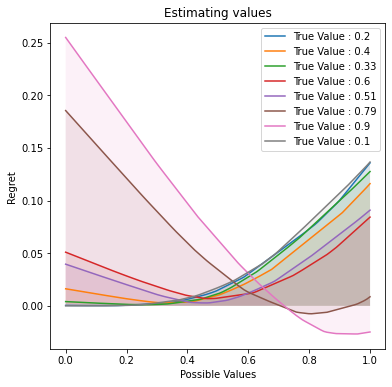

0.7777777777777778
0.393939393939394
0.4747474747474748
0.48484848484848486
0.4747474747474748


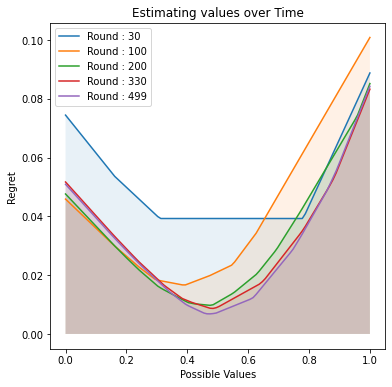

Actual regrets:
0.008646464646464647
0.015935353535353535
0.01458
0.017090909090909098
0.02051333333333333
-0.01589575757575763
-0.030745454545454565
0.0


In [5]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)

print("Estimated Values:")
for count, tracker in enumerate(trackers):
    tracker.calcRegrets()
    print(tracker.possibleValues[tracker.regrets.argmin()])
    #for count, epsilon in enumerate(epsilons):
    plt.plot(tracker.possibleValues, tracker.regrets, label = "True Value : " + str(actualValues[count]))
    plt.fill_between(tracker.possibleValues, tracker.regrets, alpha=.1)

plt.title('Estimating values')
plt.xlabel('Possible Values')
plt.ylabel('Regret')
plt.legend()
plt.show()

f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)

for count in range(5):
    print(possibleValues[regretsOverTime[count].argmin()])
    #for count, epsilon in enumerate(epsilons):
    plt.plot(possibleValues, regretsOverTime[count], label = "Round : " + str(round[count]))
    plt.fill_between(possibleValues, regretsOverTime[count], alpha=.1)

plt.title('Estimating values over Time')
plt.xlabel('Possible Values')
plt.ylabel('Regret')
plt.legend()
plt.show()

print ("Actual regrets:")
for advertiser in advertisers:
    print(advertiser.getRegret())

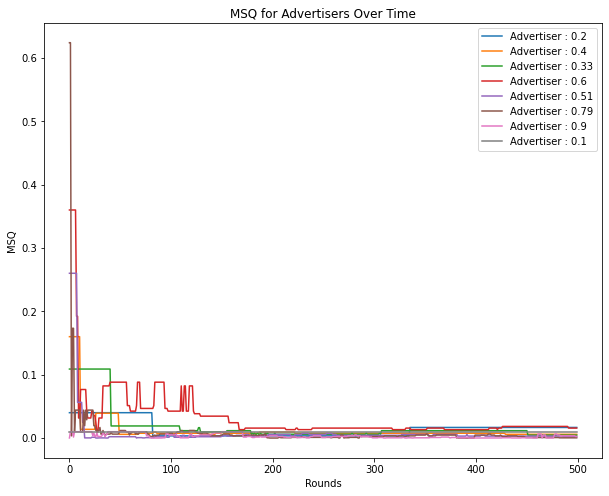

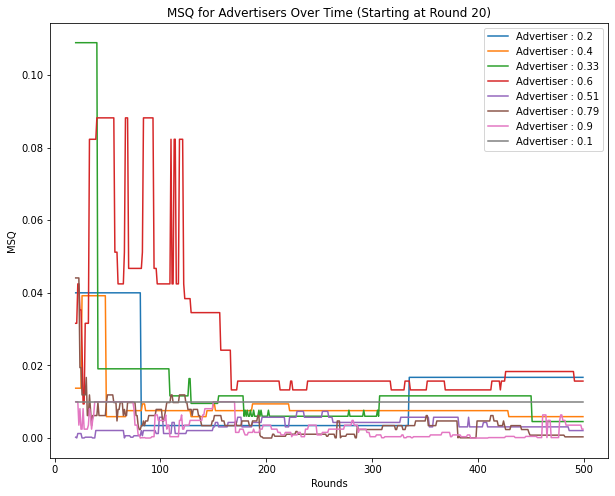

In [6]:
##graphing MSQ
#MSQ = [ [0]*8 for i in range(500)]


f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)

for count in range(8):
    plt.plot(np.arange(500), MSQ[count], label = "Advertiser : " + str(actualValues[count]))

plt.title('MSQ for Advertisers Over Time')
plt.xlabel('Rounds')
plt.ylabel('MSQ')
plt.legend()
plt.show()

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)

for count in range(8):
    plt.plot(np.arange(500)[20:500], MSQ[count][20:500], label = "Advertiser : " + str(actualValues[count]))

plt.title('MSQ for Advertisers Over Time (Starting at Round 20)')
plt.xlabel('Rounds')
plt.ylabel('MSQ')
plt.legend()
plt.show()


# print ("Actual regrets:")
# for advertiser in advertisers:
#     print(advertiser.getRegret())

### Part 2